### Leemos el dataset

In [1]:
import pandas as pd 
import os

In [2]:
ruta = r"C:\Users\uzgre\Codes\Python\Ciencia de Datos\Proyecto_final\Rest-Mex_2025_Train_DataSet"
archivo = os.path.join(ruta, "Rest-Mex_2025_train.csv") 
Data = pd.read_csv(archivo, encoding='latin-1')
print(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208051 entries, 0 to 208050
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Title     208049 non-null  object 
 1   Review    208051 non-null  object 
 2   Polarity  208051 non-null  float64
 3   Town      208051 non-null  object 
 4   Region    208051 non-null  object 
 5   Type      208051 non-null  object 
dtypes: float64(1), object(5)
memory usage: 9.5+ MB
None


In [3]:
# Si ya cargaste tu DataFrame
def arregla_mojibake(texto):
    try:
        return texto.encode('latin1').decode('utf-8')
    except:
        return texto  # Si falla la conversión, deja el texto igual

Data['Title'] = Data['Title'].fillna('').apply(arregla_mojibake)
Data['Review'] = Data['Review'].fillna('').apply(arregla_mojibake)


In [4]:
Data['Review'][208049]

'Nos toco visitar este sitio cuando ya había caido el sol, el guía nos ayudo a identificar diversas áreas de la ciudad de Creel.'

### Arreglar los valores nulos

In [ ]:
# 1. Llenar los nulos con un texto genérico
Data['Title'].fillna('Sin Titulo', inplace=True)

# 2. Eliminarlos (solo si te estorban o es irrelevante el título)
Data.dropna(subset=['Title'], inplace=True)

# 3. Dejarlo así si Title no es esencial

### Preprocesamiento de texto

In [5]:
import re
import string
import nltk
from nltk.corpus import stopwords

# Asegúrate de tener los stopwords descargados
# nltk.download('stopwords')

stopwords_es = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    texto = texto.lower()  # Minúsculas
    texto = re.sub(r'[^a-záéíóúñü\s]', '', texto)  # Quitar puntuación y caracteres raros
    palabras = texto.split()
    palabras = [palabra for palabra in palabras if palabra not in stopwords_es]  # Remover stopwords
    return ' '.join(palabras)

Data['Texto_Limpio'] = (Data['Title'].fillna('') + ' ' + Data['Review'].fillna('')).apply(limpiar_texto)

In [32]:
len(Data['Texto_Limpio'][10])

483

In [6]:
# Calcular la longitud promedio de los textos
longitudes = Data['Texto_Limpio'].apply(len)
longitud_promedio = longitudes.mean()

# Mostrar la longitud promedio
print(f"Longitud promedio de los textos: {longitud_promedio}")

# Usar un múltiplo de la longitud promedio como max_features (ajústalo según tus necesidades)
max_features_optimizado = int(longitud_promedio * 10)  # Ejemplo: multiplicar por 10
print(f"Valor sugerido para max_features: {max_features_optimizado}")


Longitud promedio de los textos: 258.19078495176666
Valor sugerido para max_features: 2581


### Representacion BOW

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

def Representacion_BoW(dataframe):
    """
    Recibe un DataFrame con la columna 'Texto_Limpio'.
    Retorna la matriz BoW como una matriz dispersa.
    """
    vectorizer = CountVectorizer(max_features=10000)
    BoW = vectorizer.fit_transform(dataframe['Texto_Limpio'])  # Transformar los textos
    print(f"Matriz BoW generada con forma: {BoW.shape}")
    return BoW, vectorizer


In [48]:
X_Bow = Representacion_BoW(Data)

Matriz BoW generada con forma: (208051, 10000)


### Representacion TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def Representacion_TF_IDF(dataframe):
    """
    Recibe un DataFrame con la columna 'Texto_Limpio'.
    Retorna la matriz TF-IDF.
    """
    textos = dataframe['Texto_Limpio'].fillna("").values
    
    vectorizer = TfidfVectorizer(
        max_features=2500,
        ngram_range=(1, 2),
        token_pattern=r'(?u)\b[^\d\W]+\b'
    )
    
    X_tfidf = vectorizer.fit_transform(textos)
    
    print(f"Matriz TF-IDF generada con forma: {X_tfidf.shape}")
    return X_tfidf, vectorizer


In [8]:
# Obtiene la matriz TF-IDF
X_tfidf, vectorizer = Representacion_TF_IDF(Data)

# Revisa un ejemplo de las palabras más importantes
#print(vectorizer.get_feature_names_out()[:10])


Matriz TF-IDF generada con forma: (208051, 2581)


### Como ver que palabra es cada indice?

In [9]:
feature_names = vectorizer.get_feature_names_out()
print(feature_names[2511])  # Te dice qué palabra es la 2911

# Revisa un ejemplo de las palabras más importantes
print(feature_names[:10])


visita obligada
['abajo' 'abierta' 'abierto' 'abre' 'abril' 'abrir' 'absolutamente'
 'absoluto' 'abundante' 'abundantes']


### Representacion Word2Vec

In [20]:
from gensim.models import Word2Vec
import numpy as np

def obtener_word2vec_promedio(dataframe):
    """
    Obtiene un vector promedio de Word2Vec para cada texto.
    """
    textos = dataframe['Texto_Limpio'].fillna("").values
    # Entrenar un modelo Word2Vec
    model = Word2Vec(sentences=textos, vector_size=100, window=5, min_count=1, workers=4)
    
    # Crear el vector promedio para cada documento
    def obtener_vector_promedio(texto):
        vectores = [model.wv[word] for word in texto if word in model.wv]
        if len(vectores) == 0:
            return np.zeros(model.vector_size)
        return np.mean(vectores, axis=0)
    
    return np.array([obtener_vector_promedio(texto) for texto in textos])


X_word2vec = obtener_word2vec_promedio(Data) 


In [21]:
X_word2vec.shape

(208051, 100)

### Vistazo a los datos en baja dimension

c:\Users\uzgre\anaconda3\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


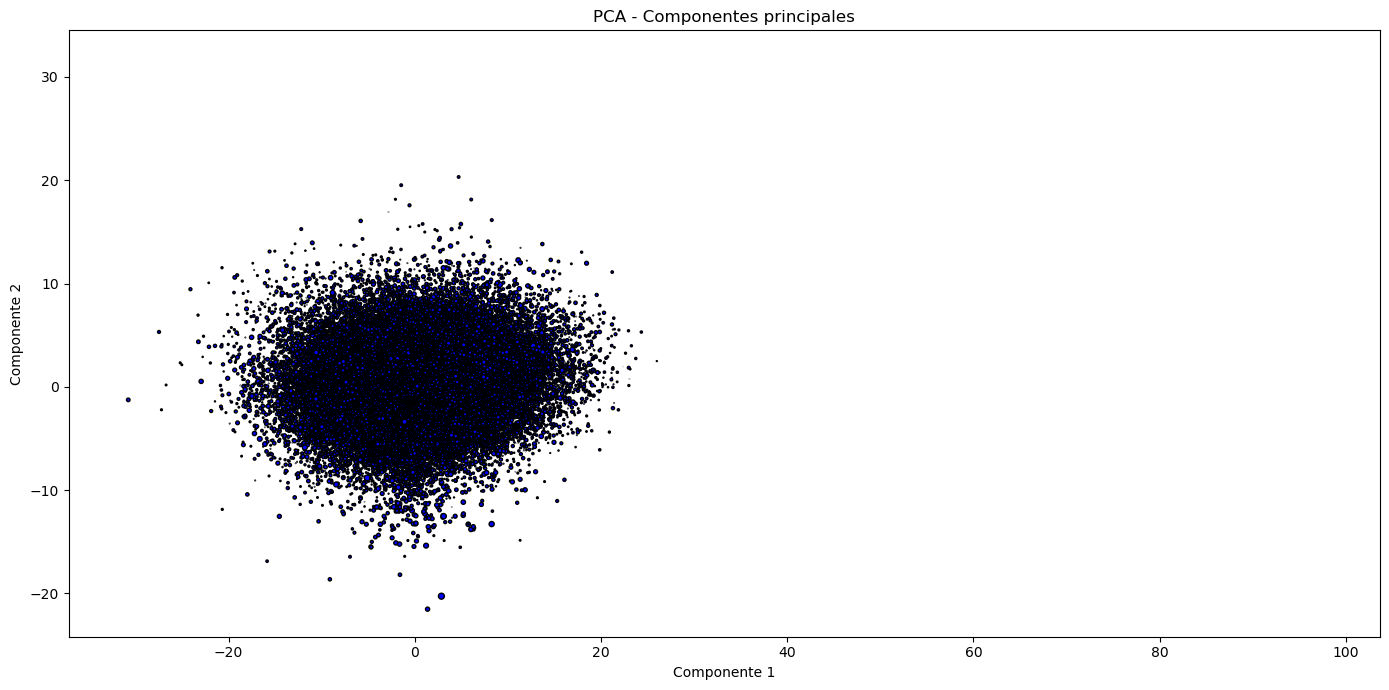

Varianza explicada por PCA: [0.31087723 0.09851586 0.09466379]


In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

def aplicar_PCA_y_KernelPCA(X):
    """
    Aplica PCA y KernelPCA a los datos para ver si es posible separar alguna estructura 
    en los primeros 2 componentes. 
    Visualiza ambos resultados.
    """
        # Tomamos una muestra del 10% de los datos
    #X = X.sample(frac=0.1, random_state=42)
    # Normalizamos los datos, sin centrar para matrices dispersas
    scaler = StandardScaler(with_mean=False)  # No centrar en matrices dispersas
    X_scaled = scaler.fit_transform(X)
    
    # PCA lineal
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)
    '''
    # KernelPCA con kernel RBF
    kernel_pca = KernelPCA(n_components=2, kernel='rbf')
    X_kernel_pca = kernel_pca.fit_transform(X_scaled)
    '''
    # Visualización PCA
    plt.figure(figsize=(14, 7))

    #plt.subplot(1, 1, 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1],X_pca[:,2], c='blue', edgecolor='k')
    plt.title('PCA - Componentes principales')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    '''
    # Visualización KernelPCA
    plt.subplot(1, 2, 2)
    plt.scatter(X_kernel_pca[:, 0], X_kernel_pca[:, 1], c='green', edgecolor='k', s=50)
    plt.title('KernelPCA - Componentes no lineales')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    '''
    plt.tight_layout()
    plt.show()

    # Imprimir varianza explicada por PCA
    print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_}")
    #print(f"Varianza explicada por KernelPCA: {X_kernel_pca.var(axis=0)}")

# Ejemplo de uso con tu matriz X_tfidf
aplicar_PCA_y_KernelPCA(X_word2vec)


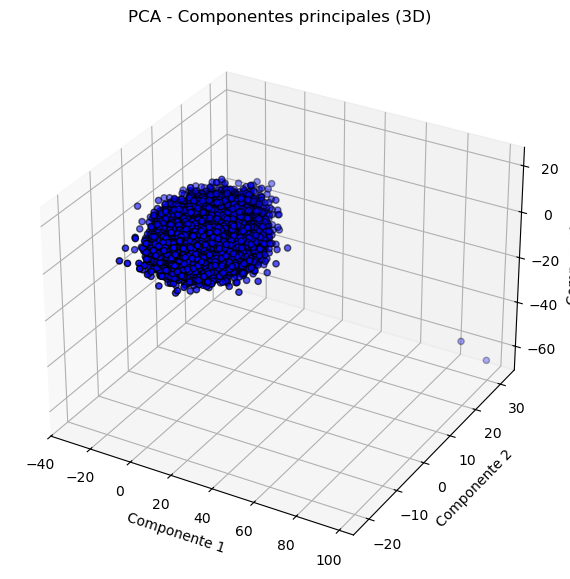

Varianza explicada por PCA: [0.31087723 0.09851586 0.09466379]


In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse import issparse

def aplicar_PCA(X):
    """
    Aplica PCA a los datos y visualiza los primeros tres componentes principales.
    """
    
    # Normalizamos los datos, sin centrar para matrices dispersas
    scaler = StandardScaler(with_mean=False)  # No centrar en matrices dispersas
    X_scaled = scaler.fit_transform(X)
    
    # PCA lineal en 3 componentes
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)
    
    # Visualización 3D de los primeros tres componentes de PCA
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c='blue', edgecolor='k')
    ax.set_title('PCA - Componentes principales (3D)')
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    ax.set_zlabel('Componente 3')
    
    plt.show()

    # Imprimir varianza explicada por PCA
    print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_}")

aplicar_PCA(X_word2vec)


In [19]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def aplicar_tSNE(X):
    """
    Aplica t-SNE para reducir la dimensionalidad de los datos a 2 dimensiones
    y visualiza el resultado.
    """
    # Tomamos una muestra del 10% de los datos para evitar problemas de memoria
    if issparse(X):
        # Tomamos una muestra del 10% de los datos de manera manual
        X = X[:int(X.shape[0] * 0.1)]
    else:
        # Si no es dispersa, usamos .sample() directamente
        X = X.sample(frac=0.1, random_state=42)
    
    # Normalizamos los datos
    scaler = StandardScaler(with_mean=False)  # No centrar en matrices dispersas
    X_scaled = scaler.fit_transform(X)
    
    # Opcionalmente, reduce la dimensionalidad con PCA antes de t-SNE para acelerar el proceso
    pca = PCA(n_components=50)  # Reducir a 50 dimensiones con PCA
    X_pca = pca.fit_transform(X_scaled)
    
    # Aplicamos t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_pca)  # Usamos los datos reducidos por PCA
    
    # Visualización
    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='blue', edgecolor='k', alpha=0.5)
    plt.title('t-SNE de los datos reducidos')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.show()

# Ejemplo de uso con tu matriz X_tfidf
aplicar_tSNE(X_tfidf)


KeyboardInterrupt: 